# Example of CNN Siamese for MNIST dataset

## Imports + model initialization

In [1]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm

from models import get_pretrained
from models.siamese import ImageSiamese
from datasets import get_dataset, prepare_dataset, test_dataset_time
from utils import plot, plot_multiple, plot_confusion_matrix, set_display_options, sample_df

set_display_options()

input_shape = (28, 28, 1)
model_name = 'mnist_siamese'
print('Tensorflow version : {}'.format(tf.__version__))

Tensorflow version : 2.10.0


In [2]:
model = ImageSiamese(input_shape, nom = model_name, distance_metric = 'euclidian')

print(model)

Set `use_mask = False` by default as the masking operation is not supported. To remove this message or change the behavior, explicitely pass `use_mask = ...`
manual padding is not supported for conv_1 (reason : not supported for 2D yet)
manual padding is not supported for conv_2 (reason : not supported for 2D yet)
manual padding is not supported for conv_3_1 (reason : not supported for 2D yet)
manual padding is not supported for conv_3_2 (reason : not supported for 2D yet)
manual padding is not supported for conv_4_1 (reason : not supported for 2D yet)
manual padding is not supported for conv_5_1 (reason : not supported for 2D yet)
Initializing model with kwargs : {'siamese': {'architecture_name': 'siamese', 'model': <keras.engine.sequential.Sequential object at 0x000001F99B587EB0>, 'distance_metric': 'euclidian', 'input_shape': (28, 28, 1)}}
Initializing submodel : `siamese` !
Submodel siamese saved in pretrained_models\mnist_siamese\saving\siamese.json !
Model mnist_siamese initializ

## Model instanciation + dataset loading

In [3]:
model = get_pretrained(model_name)

model.compile()

print(model)
#model.summary()

Optimizer 'siamese_optimizer' initilized successfully !
Submodel siamese compiled !
  Loss : {'reduction': 'none', 'name': 'binary_crossentropy', 'from_logits': False, 'label_smoothing': 0.0, 'axis': -1}
  Optimizer : {'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
  Metrics : [{'name': 'binary_accuracy', 'dtype': 'float32', 'threshold': 0.5}, {'name': 'EER', 'dtype': 'float32', 'num_thresholds': 200, 'curve': 'ROC', 'summation_method': 'interpolation', 'multi_label': False, 'num_labels': None, 'label_weights': None, 'from_logits': False}]

========== mnist_siamese ==========
Sub model siamese
- Inputs 	: [(None, 28, 28, 1), (None, 28, 28, 1)]
- Outputs 	: (None, 1)
- Number of layers 	: 4
- Number of parameters 	: 2.629 Millions
- Optimizer 	: {'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
- Loss 	 : {'reduction': 'none', 'name': 'binar

In [ ]:
def to_pandas(ds):
    return pd.DataFrame([
        {'id' : sample['label'].numpy(), 'image' : sample['image'].numpy()}
        for sample in ds
    ])

ds = get_dataset('mnist')

train, valid = to_pandas(ds['train']), to_pandas(ds['test'])

print("Train size : {} - Valid size : {}".format(len(train), len(valid)))

## Training + history analysis

Explaination for metrics : 
- The `Binary Accuracy` computes the average number of correct predictions based on a fixed threshold (0.5 here)
- The `AUC` computes accuracies based on many different thresholds (ROC curve) and takes the area below the curve
- The `EER` is the score at which the true positive rate and the false positive rate are equal (it can be interpreted as an approximation of `1. - accuracy` at the best threshold)

It is the reason why the AUC can be around 0.7 and the binary accuracy around 0.6 (1st epoch), because the model well separates data but not with a threshold of 0.5. This is shown by next steps where the binary accuracy increases well, as the model learns to better separate data (and so the binary accuracy is happier !). 

The `max_by_id` argument is the number of pairs of data for each class. With 1000, it means that the model is trained on 1000 same pairs and 1000 not-same pairs for each class in the MNIST dataset.

We can also observe that the model is trained on 157 batches / epochs, and see 64 pairs of "same" and 64 pairs "no-same" per batch (the effective `batch_size` is therefore 128).

Note that based on history graphes, the model seems to not finished its convergence, so it may reach a better score (which is not necessary for this demonstation) ;)

In [5]:
model.train(
    train, validation_data = valid,
    epochs = 15, batch_size = 64, pred_step = 2500,
    augment_prct = 0.25, max_by_id = 1000
)

Training config :
HParams :
- augment_prct	: 0.25
- augment_methods	: ['noise']
- batch_size	: 64
- train_batch_size	: None
- valid_batch_size	: None
- test_batch_size	: 1
- shuffle_size	: 1024
- epochs	: 15
- verbose	: 1
- train_times	: 1
- valid_times	: 1
- train_size	: None
- valid_size	: None
- test_size	: 4
- pred_step	: 2500

Running on 1 GPU

Epoch 1 / 15
Epoch 1/15
157/157 [==============================] - 19s 71ms/step - loss: 0.6580 - binary_accuracy: 0.5874 - EER: 0.3235 - AUC: 0.6826 - val_loss: 0.7199 - val_binary_accuracy: 0.6133 - val_EER: 0.3947 - val_AUC: 0.6780

Saving at epoch 1 !

Epoch 2 / 15
Epoch 2/15
157/157 [==============================] - 10s 65ms/step - loss: 0.5587 - binary_accuracy: 0.7710 - EER: 0.2446 - AUC: 0.8002 - val_loss: 0.5224 - val_binary_accuracy: 0.7655 - val_EER: 0.1860 - val_AUC: 0.8796

Saving at epoch 2 !

Epoch 3 / 15
Epoch 3/15
157/157 [==============================] - 10s 65ms/step - loss: 0.4749 - binary_accuracy: 0.8442 - EER: 0.166

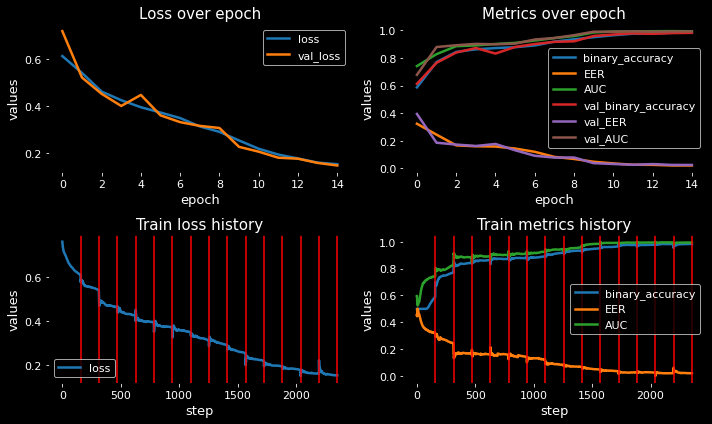

===== History =====
        loss  binary_accuracy      EER       AUC  val_loss  val_binary_accuracy  val_EER   val_AUC
0   0.613725          0.58735  0.32355  0.741592  0.719900              0.61335  0.39475  0.678047
1   0.542014          0.77095  0.24460  0.828070  0.522444              0.76545  0.18605  0.879557
2   0.462763          0.84420  0.16690  0.885553  0.453225              0.83955  0.17285  0.892620
3   0.425912          0.86310  0.16035  0.891273  0.401402              0.87245  0.16255  0.902313
4   0.396001          0.87195  0.15855  0.901732  0.448300              0.83215  0.17715  0.899384
5   0.373486          0.87815  0.14400  0.909585  0.361498              0.87995  0.13150  0.904295
6   0.349906          0.89110  0.12030  0.926475  0.332611              0.90130  0.09170  0.934048
7   0.314318          0.91885  0.08345  0.944471  0.316685              0.91730  0.07845  0.944806
8   0.291276          0.93540  0.06855  0.958778  0.307666              0.92110  0.07920 

In [6]:
model.plot_history()
print(model.history)

## Embeddings

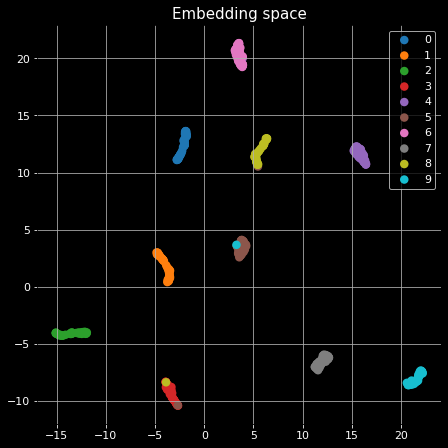

In [7]:
datas = sample_df(valid, n = 10, n_sample = 50)

model.plot_embedding(datas)

## Prediction

### Comparaison

Note : the `decode_output` method is used as the model may either predict a *similarity* or *distance* score (i.e. the probability that the two inputs data are *same* or *not same*) (cf the `output_similarity` config). The decision is also impacted by the `threshold` choice. The `decode_output` puts it all together to return a binary decision (`True` = *same*, and *not same* otherwise), which is easier to interpret and use !

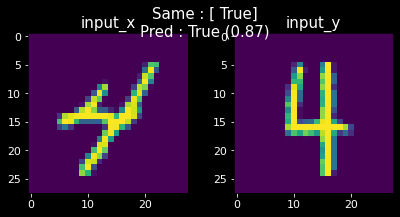

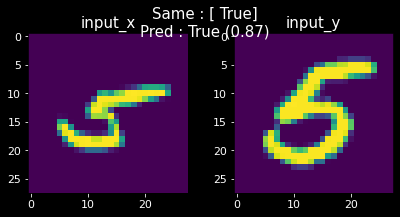

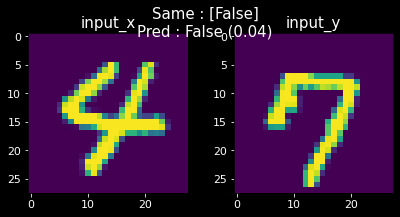

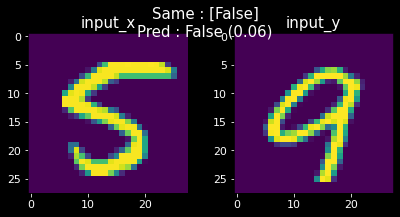

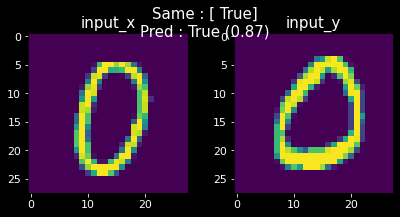

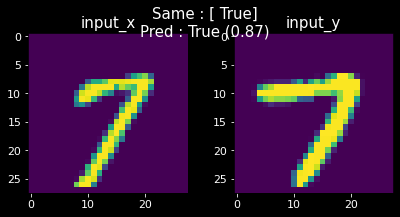

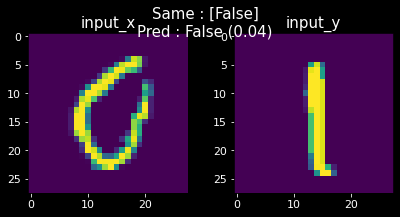

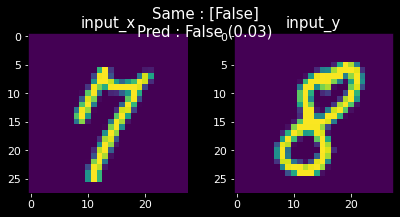

In [8]:
config = model.get_dataset_config(is_validation = True, batch_size = 2)

ds_train = prepare_dataset(train, ** config)

n = 2
for i, (inputs, target) in enumerate(ds_train):
    if i >= n: break
    
    x, y = inputs
    
    scores = tf.squeeze(model(inputs))
    pred   = model.decode_output(scores)
    target = model.decode_output(tf.cast(target, tf.float32))
    
    data = {}
    for i, (xi, yi, ti, si, pi) in enumerate(zip(x, y, target, scores, pred)):
        plot_multiple(
            input_x = xi, input_y = yi, plot_type = 'imshow', size = 3,
            title = 'Same : {}\nPred : {} ({:.2f})'.format(ti, pi, float(si))
        )


### Class prediction

The `K-NN` algorithm is used to classify new data based on a set of labelled `samples` (which are the labelled points for the `k-nn`).

Note : the accuracy is **not** representative as you compute it only on 40 test samples (4 for each class) which is far too low. Furthermore,  250 samples of each class are used (i.e. 2500 labelled points) which is a small part of the real training set. This samples-size influences the final prediction (and thus the accuracy)

If you do the test : 
- With `use_mean = True`, I got accuracy between 0.9 and 0.6 depending on `n_saple` and the run (because sampling is random !)
- However, with `k == 7` I got accuracy > 90% for the 5 runs I made !

Note : you can check the `evaluation` section to see the impact of `k`, `use_mean` and `sample_size` while evaluating on the whole validation set : the `accuracy` is not really affected by these parameters (less than 1%)

The big dots are the *centroids*, the small dots are *labelled data* and the *x* are the data to classify. An interesting aspect is that some points are wrongly encoded (the dots with another color than the cluster) but it is not an issue for the classification thanks to the `k` parameter !

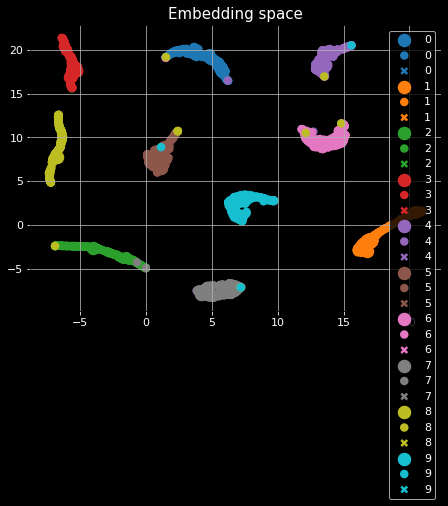

Accuracy : 0.95


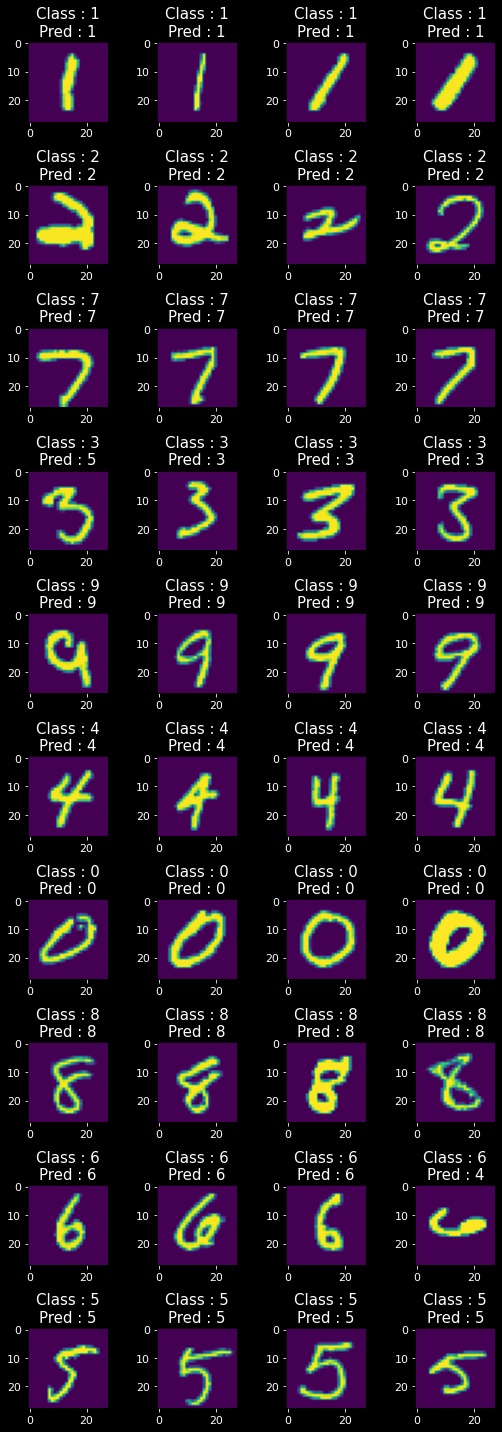

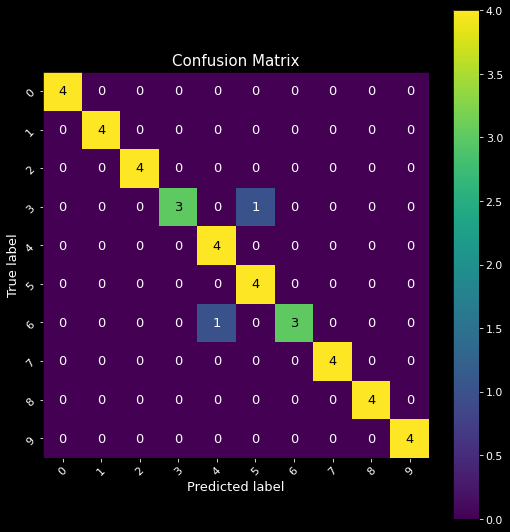

In [9]:
samples = sample_df(train, n = 10, n_sample = 250)
embedded_samples = model.embed(samples)

valid_samples = sample_df(valid, n = 10, n_sample = 4)

ids    = valid_samples['id'].values
images = valid_samples['image'].values
pred   = model.recognize(
    valid_samples, samples = embedded_samples, ids = samples['id'].values, k = 7, plot = True
)

predictions = {
    'pred_{}'.format(i) : {'x' : images[i], 'title' : 'Class : {}\nPred : {}'.format(id_i, pred_i)}
    for i, (id_i, pred_i) in enumerate(zip(ids, pred))
}

print("Accuracy : {:.2f}".format(np.sum(ids == pred) / len(pred)))

plot_multiple(
    ** predictions, plot_type = 'imshow', ncols = 4, size = 2
)
plot_confusion_matrix(true =  ids, pred = pred)

## Evaluation

In the below cell, the model is evaluated based on its classification performances. It means that the model is used as a classifier, based on the `recognize` method (the other evaluation methods are not shown because... I have not implemented them yet :D )

We can observe that the impact of the `K` hyperparameters is quite low (less than 1% differences). As we can see on above plots, only 1 or 2 points are clearly in the wrong cluster. It explaines why using `k-nn` based on the centroids is not impacted by these outliers, which is also the case when using (at least) 3 or 5 for the `k-nn`

Note that `use_mean` is not impacted by the outliers because we use a large number of points and clusters are far enough. It may be not the case for other applications such as the `AudioSiamese` test where we have small number of datas / ids and much more different ids so I guess outliers can have a bigger impact

An interesting point to note is that the obtained `accuracy` (around 97.5%) is close to the `binary accuracy` computed during training ! This can be useful because it is faster to evaluate, easier to compute and has a better support with the `History` callback (which is note yet supported by the custom `evaluate` method)*

However we **cannot** generalize this property because a counter-example is shown in the `example_fashion_mnist`. However the accuracy for the `fashion_mnist` model is far lower than this one so a first idea could be : the higher the `binary_accuracy`, the higher the `accuracy` and then the lower the differences (but has to be confirmed by experiments) 

\* If you want to evaluate the model based on the classical metrics, you can use the `test` method, which is equivalent to `train` but only for evaluation procedure

In [10]:
t0 = time.time()
results = model.evaluate(valid, samples = train, sample_size = 250, k = 5)
print("Accuracy : {:.2f}% (evaluation time : {:.3f} sec)".format(results['metrics']['accuracy'] * 100, time.time() - t0))

Accuracy : 98.34% (evaluation time : 27.061 sec)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:30<00:00, 12.93s/it]


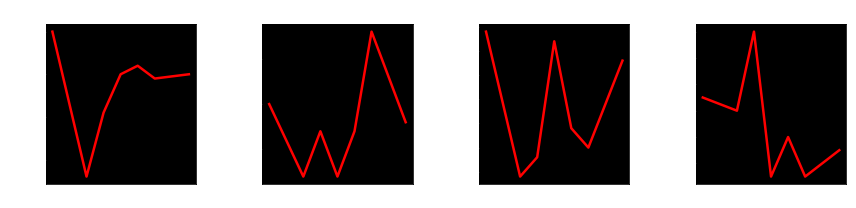

In [5]:
datas = {}
k_values = [-1, 3, 5, 7, 9, 11, 15]
for i, sample_size in enumerate([50, 100, 250, 500]):
    datas['pred_{}'.format(i)] = {
        'x' : k_values,
        'y' : [model.evaluate(
            valid, samples = train, sample_size = sample_size,  k = k, use_mean = k == -1
        ) for k in tqdm(k_values)],
        'title' : '{} samples'.format(sample_size)
    }
plot_multiple(** datas, ncols = 4, size = 3, use_subplots = True)

## Dataset analysis

Here we can see examples of pairs of same / not same labels : **it is the most important part** to be sure datas are well associated and avoid to lose time training on wrong datas !

tf.Tensor(
[[1]
 [1]
 [0]
 [0]], shape=(4, 1), dtype=int32)


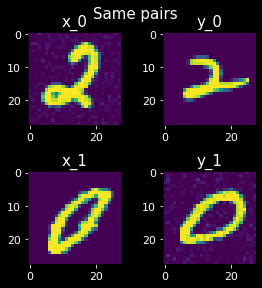

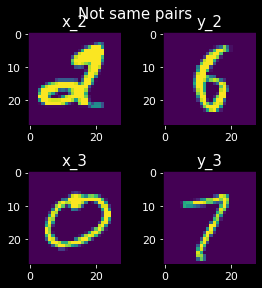

tf.Tensor(
[[1]
 [1]
 [0]
 [0]], shape=(4, 1), dtype=int32)


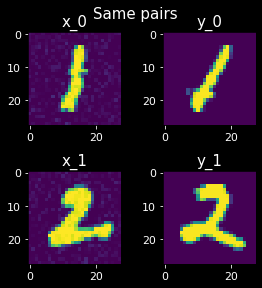

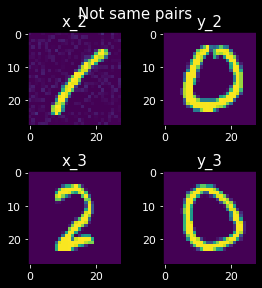

In [11]:
config = model.get_dataset_config(is_validation = False, batch_size = 2)

ds_train = prepare_dataset(train, ** config)

n = 2
for i, (inputs, target) in enumerate(ds_train):
    if i >= n: break
    
    (x, y) = inputs
    
    print(target)
    sames, not_sames = {}, {}
    for i, (xi, yi) in enumerate(zip(x, y)):
        if i < len(x) // 2:
            sames.update({
                'x_{}'.format(i) : xi,
                'y_{}'.format(i) : yi
            })
        else:
            not_sames.update({
                'x_{}'.format(i) : xi,
                'y_{}'.format(i) : yi
            })
    
    plot_multiple(
        title = 'Same pairs', ** sames, plot_type = 'imshow', size = 2
    )
    plot_multiple(
        title = 'Not same pairs', ** not_sames, plot_type = 'imshow', size = 2
    )
